### What does the Schrödinger workflow do?
- Read in sdfs
- MM
- ionize at pH 7
- desalt
- generate tautomers
- retain chirality as specified in input
- reaction-based enumeration

### What does Yu's second script (SDFtoFormula) do?
- Read in SDFs
- Calculate molecular formula
- write to file

### What is the better rdkit/python equivalent to these?
- take the df of mols (from pickle)
- desalt
- reaction enumeration

In [499]:
from rdkit import Chem
from rdkit.Chem import Draw, SaltRemover, AllChem, FunctionalGroups, rdFMCS, DetectChemistryProblems
from rdkit.Chem.SimpleEnum.Enumerator import EnumerateReaction
from rdkit.Chem.PropertyMol import PropertyMol
from pathlib import Path
import pandas as pd
import warnings
import string
import itertools

In [442]:
DATA_DIR = Path('..', 'data').resolve()
OUTPUT_DIR = DATA_DIR / 'outputs'

In [443]:
compounds = pd.read_pickle(OUTPUT_DIR / 'library_constituents_dataframe.pkl')
compounds

,Compound Name,SMILES,Category,mol,img,MW_from_mol,weigh-in [mg] / 100 µL
0,2-Pyr002,C1=NC(C([B-](F)(F)F)=O)=CC(Cl)=C1.[K+],I,<rdkit.Chem.PropertyMol.PropertyMol object at ...,<PIL.Image.Image image mode=RGBA size=300x300 ...,247.453,1.24
1,2-Pyr003,C1(Cl)C=CC=C(C(=O)[B-](F)(F)F)N=1.[K+],I,<rdkit.Chem.PropertyMol.PropertyMol object at ...,<PIL.Image.Image image mode=RGBA size=300x300 ...,247.453,1.24
2,2-Pyr005,C1(Br)C=CC=C(C(=O)[B-](F)(F)F)N=1.[K+],I,<rdkit.Chem.PropertyMol.PropertyMol object at ...,<PIL.Image.Image image mode=RGBA size=300x300 ...,291.904,1.46
3,2-Pyr006,C1C(Br)=CC=C(C(=O)[B-](F)(F)F)N=1.[K+],I,<rdkit.Chem.PropertyMol.PropertyMol object at ...,<PIL.Image.Image image mode=RGBA size=300x300 ...,291.904,1.46
4,2-Pyr007,C1(F)C=CC=C(C(=O)[B-](F)(F)F)N=1.[K+],I,<rdkit.Chem.PropertyMol.PropertyMol object at ...,<PIL.Image.Image image mode=RGBA size=300x300 ...,230.998,1.15
...,...,...,...,...,...,...,...
188,TerTH023,S=C(C1C=CC=C2NN=CC=12)NN.Cl,T,<rdkit.Chem.PropertyMol.PropertyMol object at ...,<PIL.Image.Image image mode=RGBA size=300x300 ...,228.708,1.14
189,TerTH025,S=C(C1N=CNC=1)NN.Cl,T,<rdkit.Chem.PropertyMol.PropertyMol object at ...,<PIL.Image.Image image mode=RGBA size=300x300 ...,178.648,0.89
190,TerTH026,S=C(C1C=NNC=1)NN.Cl,T,<rdkit.Chem.PropertyMol.PropertyMol object at ...,<PIL.Image.Image image mode=RGBA size=300x300 ...,178.648,0.89
191,TerTH027,S=C(C1C=CC2NN=NC=2C=1)NN.Cl,T,<rdkit.Chem.PropertyMol.PropertyMol object at ...,<PIL.Image.Image image mode=RGBA size=300x300 ...,229.696,1.15


In [444]:
# desalt the building block library
remover = SaltRemover.SaltRemover()
compounds['desalted'] = compounds.loc[:, 'mol'].apply(remover.StripMol)


In [445]:
def deprotonate_nitrogen(mol):
    """Remove a proton from ammonium species"""
    mol.UpdatePropertyCache()
    print(f'Next: {AllChem.CalcMolFormula(mol)}')
    patt = Chem.MolFromSmarts('[#7+;H1,H2,H3,h1,h2,h3]')  # this pattern matches positive N with at least one proton attached
    try:
        idx = mol.GetSubstructMatches(patt)[0][0]  # this raises IndexError if patt is not found
        atom = mol.GetAtomWithIdx(idx)  # get the atom index of the charged N
        atom.SetFormalCharge(0)
        """If H are explicit, we have to do explicit removal. If they are implicit, calling UpdatePropertyCache() suffices"""
        n_hyd = atom.GetNumExplicitHs()
        if n_hyd > 0:
            n_hyd -= 1
            atom.SetNumExplicitHs(n_hyd)
        mol.UpdatePropertyCache()
    except IndexError:
        print('No charged nitrogen found')
    print(f'.....{AllChem.CalcMolFormula(mol)}')
    return None

In [446]:
# neutralize ammoniums
compounds.loc[:, 'desalted'].apply(deprotonate_nitrogen)
# Draw.MolsToGridImage(compounds['neutral'].values, maxMols=300)

Next: C6H3BClF3NO-
No charged nitrogen found
.....C6H3BClF3NO-
Next: C6H3BClF3NO-
No charged nitrogen found
.....C6H3BClF3NO-
Next: C6H3BBrF3NO-
No charged nitrogen found
.....C6H3BBrF3NO-
Next: C6H3BBrF3NO-
No charged nitrogen found
.....C6H3BBrF3NO-
Next: C6H3BF4NO-
No charged nitrogen found
.....C6H3BF4NO-
Next: C6H3BF4NO-
No charged nitrogen found
.....C6H3BF4NO-
Next: C7H6BF3NO2-
No charged nitrogen found
.....C7H6BF3NO2-
Next: C7H6BF3NO2-
No charged nitrogen found
.....C7H6BF3NO2-
Next: C5H3BF3OS-
No charged nitrogen found
.....C5H3BF3OS-
Next: C5H3BF3O2-
No charged nitrogen found
.....C5H3BF3O2-
Next: C6H3BBrF3NO-
No charged nitrogen found
.....C6H3BBrF3NO-
Next: C6H4BF3NO-
No charged nitrogen found
.....C6H4BF3NO-
Next: C8H9BF3N2O-
No charged nitrogen found
.....C8H9BF3N2O-
Next: C5H3BF3OS-
No charged nitrogen found
.....C5H3BF3OS-
Next: C6H5BF3N2O2-
No charged nitrogen found
.....C6H5BF3N2O2-
Next: C6H3BClF3NO-
No charged nitrogen found
.....C6H3BClF3NO-
Next: C4H3BF3N2O-
No c

0      None
1      None
2      None
3      None
4      None
       ... 
188    None
189    None
190    None
191    None
192    None
Name: desalted, Length: 193, dtype: object

In [447]:
compounds['desalted_SMILES'] = compounds.loc[:, 'desalted'].apply(Chem.MolToSmiles)

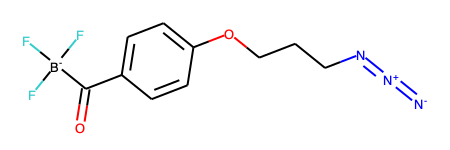

In [448]:
compounds.loc[46, 'desalted']

In [449]:
# this works for TerTH / prod A >>
rxn = AllChem.ReactionFromSmarts('F[B-](F)(F)[#6](-[*:1])=O.O=[#6]1-[#8]C2([#6]-[#6]-[#6]-[#6]-[#6]2)[#8]C11[#6:3]-[#6:2]-[#7]-[#8]1.[#6:4]-[#6](=S)-[#7]-[#7]>>[#6:4]-[#6]-1=[#7]-[#7]=[#6](-[#6:3]-[#6:2]-[#7]-[#6](-[*:1])=O)-[#16]-1')

# this attempts making all 7 TerTH prods at once
rxn_TH = AllChem.ReactionFromSmarts('F[B-](F)(F)[#6](-[*:1])=O.O=[#6]1-[#8]C2([#6]-[#6]-[#6]-[#6]-[#6]2)[#8]C11[#6:3]-[#6:2]-[#7]-[#8]1.[#6:4]-[#6](=S)-[#7]-[#7]>>[#6:4]-[#6]-1=[#7]-[#7]=[#6](-[#6:3]-[#6:2]-[#7]-[#6](-[*:1])=O)-[#16]-1.[#6:4]-[#6]-1=[#7]-[#7]C([#6:3]-[#6:2]-[#7]-[#6](-[*:1])=O)([#16]-1)[#6](-[#8])=O.[#6:4]-[#6]-1=[#7]-[#7+]-2=[#6](-[*:1])-[#7]-[#6:2]-[#6:3]-[#6]-2-[#16]-1.[#6:4]-[#6]-1=[#7]-[#7]=[#6](-[*:1])-[#16]-1.[#6:4]-[#6]-1=[#7]-[#7]=[#6](-[#6:4])-[#16]-1.[#8]-[#6](=O)-[#6](=O)-[#6:3]-[#6:2]-[#7]-[#6](-[*:1])=O.[#8]-[#6](=O)-[#6:3]-[#6:2]-[#7]-[#6](-[*:1])=O')

# all 7 TerABT prods
rxn_ABT = AllChem.ReactionFromSmarts('F[B-](F)(F)[#6](-[*:1])=O.O=[#6]1-[#8]C2([#6]-[#6]-[#6]-[#6]-[#6]2)[#8]C11[#6:3]-[#6:2]-[#7]-[#8]1.[#7]-c1[c:4][c:5][c:6][c:7]c1-[#16]>>[*:1]-[#6](=O)-[#7]-[#6:2]-[#6:3]-c1nc2[c:4][c:5][c:6][c:7]c2s1.[#8]-[#6](=O)C1([#6:3]-[#6:2]-[#7]-[#6](-[*:1])=O)[#7]-c2[c:4][c:5][c:6][c:7]c2-[#16]1.[*:1]-[#6]-1=[#7+]-2-[#6](-[#6:3]-[#6:2]-[#7]-1)-[#16]-c1[c:7][c:6][c:5][c:4]c-21.[*:1]-c1nc2[c:4][c:5][c:6][c:7]c2s1.[#7]-c1[c:4][c:5][c:6][c:7]c1-[#16]-[#16]-c1[c:7][c:6][c:5][c:4]c1-[#7].[#8]-[#6](=O)-[#6](=O)-[#6:3]-[#6:2]-[#7]-[#6](-[*:1])=O.[#8]-[#6](=O)-[#6:3]-[#6:2]-[#7]-[#6](-[*:1])=O')

In [450]:
AllChem.Compute2DCoordsForReaction(rxn)
AllChem.Compute2DCoordsForReaction(rxn_TH)
AllChem.Compute2DCoordsForReaction(rxn_ABT)

rxn.Initialize()
n_warn, n_err = rxn.Validate()
if n_err > 0:
    raise ValueError(f'Invalid reaction gave {n_err} errors in validation')
rxn_TH.Initialize()
n_warn, n_err = rxn_TH.Validate()
if n_err > 0:
    raise ValueError(f'Invalid reaction gave {n_err} errors in validation')
rxn_ABT.Initialize()
n_warn, n_err = rxn_ABT.Validate()
if n_err > 0:
    raise ValueError(f'Invalid reaction gave {n_err} errors in validation')

RDKit WARNING: [17:52:33] product atom-mapping number 2 found multiple times.
RDKit WARNING: [17:52:33] product atom-mapping number 7 found multiple times.
RDKit WARNING: [17:52:33] product atom-mapping number 6 found multiple times.
RDKit WARNING: [17:52:33] product atom-mapping number 5 found multiple times.
RDKit WARNING: [17:52:33] product atom-mapping number 4 found multiple times.
RDKit WARNING: [17:52:33] product atom-mapping number 1 found multiple times.
RDKit WARNING: [17:52:33] product atom-mapping number 4 found multiple times.
RDKit WARNING: [17:52:33] product atom-mapping number 5 found multiple times.
RDKit WARNING: [17:52:33] product atom-mapping number 6 found multiple times.
RDKit WARNING: [17:52:33] product atom-mapping number 7 found multiple times.
RDKit WARNING: [17:52:33] product atom-mapping number 4 found multiple times.
RDKit WARNING: [17:52:33] product atom-mapping number 5 found multiple times.
RDKit WARNING: [17:52:33] product atom-mapping number 6 found mu

RDKit WARNING: [17:58:24] product atom-mapping number 5 found multiple times.
RDKit WARNING: [17:58:24] product atom-mapping number 6 found multiple times.
RDKit WARNING: [17:58:24] product atom-mapping number 7 found multiple times.
RDKit WARNING: [17:58:24] product atom-mapping number 1 found multiple times.
RDKit WARNING: [17:58:24] product atom-mapping number 3 found multiple times.
RDKit WARNING: [17:58:24] product atom-mapping number 2 found multiple times.
RDKit WARNING: [17:58:24] product atom-mapping number 7 found multiple times.
RDKit WARNING: [17:58:24] product atom-mapping number 6 found multiple times.
RDKit WARNING: [17:58:24] product atom-mapping number 5 found multiple times.
RDKit WARNING: [17:58:24] product atom-mapping number 4 found multiple times.
RDKit WARNING: [17:58:24] product atom-mapping number 1 found multiple times.
RDKit WARNING: [17:58:24] product atom-mapping number 4 found multiple times.
RDKit WARNING: [17:58:24] product atom-mapping number 5 found mu

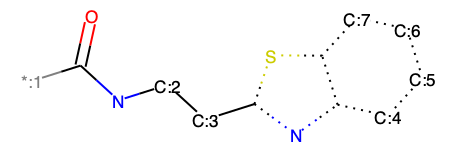

In [451]:
AllChem.PreprocessReaction(rxn_ABT)
t = rxn_ABT.GetProducts()
t[0]

In [452]:
tent_prod = Chem.MolFromSmarts('Br[#6]-1=[#6]-[#6]-2=[#6](-[#16]-[#6](-[#6]-[#6@H](-[#6]-[#6]-[#6]-3=[#6]-[#6]=[#6]-[#6]=[#6]-3)-[#7]-[#6](=O)-[#6]-3-[#6]-[#6]-[#6]-[#6]-[#6]-3)=[#7]-2)-[#6]=[#6]-1')
tent_prod_2 = Chem.MolFromSmarts('[#6]-[#7]-[#6](=O)-[#7]-[#6]-[#6@H](-[#6])-[#6]-1=[#7]-[#6]-2=[#6](-[#16]-1)-[#6](-[#7])=[#6]-[#6]=[#6]-2-[#6]')
tps = [tent_prod, tent_prod_2]
[Chem.SanitizeMol(x) for x in tps]

[rdkit.Chem.rdmolops.SanitizeFlags.SANITIZE_NONE,
 rdkit.Chem.rdmolops.SanitizeFlags.SANITIZE_NONE]

In [453]:
tps[1].HasSubstructMatch(t[0])
# tps[0]

True

In [454]:
r = rdFMCS.FindMCS(tps)
r.smartsString

'[#6](=[#8])-[#7]-[#6]-[#6]-[#6]1:[#7]:[#6]2:[#6](:[#16]:1):[#6]:[#6]:[#6]:[#6]:2'

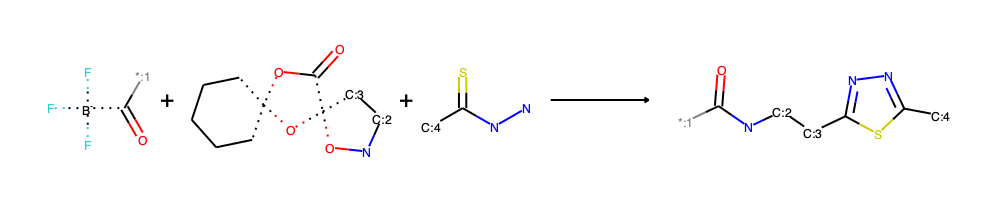

In [455]:
Draw.ReactionToImage(rxn)

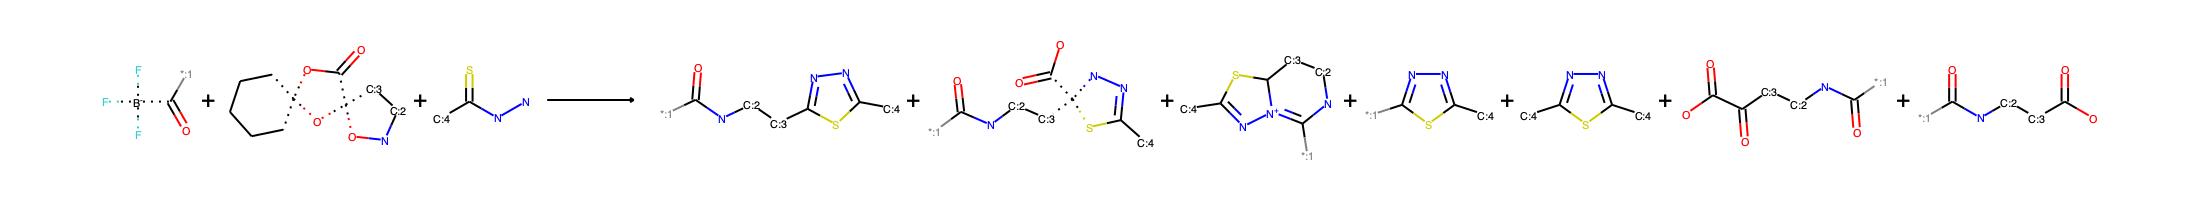

In [456]:
Draw.ReactionToImage(rxn_TH)

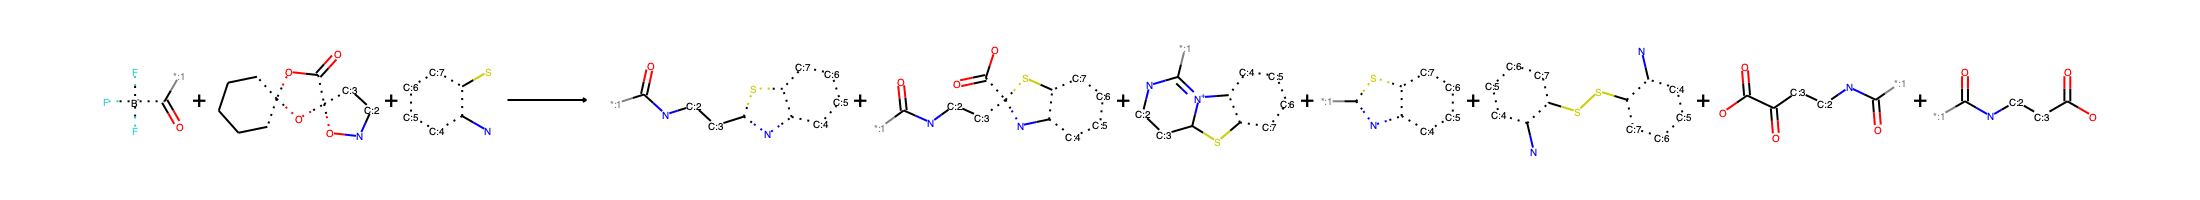

In [457]:
Draw.ReactionToImage(rxn_ABT)

In [458]:
# some checks
# idx 46 is KAT, 54 Fused, 100 Mon, 138 Spiro, 160 is TerABT, 180 is TerTH
r_KAT = compounds.loc[46, 'desalted']
r_Fused = compounds.loc[54, 'desalted']
r_Mon = compounds.loc[100, 'desalted']
r_Spiro = compounds.loc[138, 'desalted']
r_TerABT = compounds.loc[160, 'desalted']
r_TerTH = compounds.loc[180, 'desalted']

In [459]:
for i in r_TerABT.GetAromaticAtoms():
    print(i)

In [460]:
"""define reagents"""
all_KAT = compounds[compounds.loc[:, 'Category'].str.startswith('I')]
all_Mon = compounds[compounds.loc[:, 'Category'].str.startswith('M')]
all_Spiro = compounds[compounds.loc[:, 'Compound Name'].str.startswith('Spiro')]
all_Fused = compounds[compounds.loc[:, 'Compound Name'].str.startswith('Fused')]
all_Sub = compounds[compounds.loc[:, 'Compound Name'].str.startswith('Mon')]
all_TerTH = compounds[compounds.loc[:, 'Compound Name'].str.startswith('TerTH')]
all_TerABT = compounds[compounds.loc[:, 'Compound Name'].str.startswith('TerABT')]

In [461]:
"""info"""
print(f'KATs: {all_KAT.shape[0]}')
print(f'Mons: {all_Mon.shape[0]}')
print(f' - Spiro: {all_Spiro.shape[0]}')
print(f' - Fused: {all_Fused.shape[0]}')
print(f' - Sub: {all_Sub.shape[0]}')
print(f'TerTHs: {all_TerTH.shape[0]}')
print(f'TerABTs: {all_TerABT.shape[0]}')
print()
print(f'expected TH (A) products: {all_KAT.shape[0] * all_Mon.shape[0] * all_TerTH.shape[0]}')
print(f' - expected TH (A) products (spiro): {all_KAT.shape[0] * all_Spiro.shape[0] * all_TerTH.shape[0]}')
print(f' - expected TH (A) products (fused): {all_KAT.shape[0] * all_Fused.shape[0] * all_TerTH.shape[0]}')
print(f' - expected TH (A) products (sub): {all_KAT.shape[0] * all_Sub.shape[0] * all_TerTH.shape[0]}')
print()
print(f'expected ABT (A) products: {all_KAT.shape[0] * all_Mon.shape[0] * all_TerABT.shape[0]}')
print(f' - expected ABT (A) products (spiro): {all_KAT.shape[0] * all_Spiro.shape[0] * all_TerABT.shape[0]}')
print(f' - expected ABT (A) products (fused): {all_KAT.shape[0] * all_Fused.shape[0] * all_TerABT.shape[0]}')
print(f' - expected ABT (A) products (sub): {all_KAT.shape[0] * all_Sub.shape[0] * all_TerABT.shape[0]}')

KATs: 78
Mons: 74
 - Spiro: 16
 - Fused: 8
 - Sub: 50
TerTHs: 23
TerABTs: 18

expected TH (A) products: 132756
 - expected TH (A) products (spiro): 28704
 - expected TH (A) products (fused): 14352
 - expected TH (A) products (sub): 89700

expected ABT (A) products: 103896
 - expected ABT (A) products (spiro): 22464
 - expected ABT (A) products (fused): 11232
 - expected ABT (A) products (sub): 70200


In [462]:
I = all_KAT['desalted'].tolist()
M = all_Mon['desalted'].tolist()
fused = all_Fused['desalted'].tolist()
spiro = all_Spiro['desalted'].tolist()
sub = all_Sub['desalted'].tolist()
T_TH = all_TerTH['desalted'].tolist()
T_ABT = all_TerABT['desalted'].tolist()

In [463]:
res=rdFMCS.FindMCS(T_ABT)
res.smartsString

'[#6]1:[#6]:[#6]:[#6](:[#6](:[#6]:1)-[#7])-[#16]'

In [464]:
"""check if any of the desired reactants does not work as a reactant in TH reaction"""
TH_reactants = pd.concat([all_KAT, all_Mon, all_TerTH])
not_reactant = TH_reactants[~TH_reactants.loc[:, 'desalted'].apply(rxn_TH.IsMoleculeReactant)]
if len(not_reactant) > 0:
    warnings.warn('A molecule could not be assigned as reactant with the current reaction definition.', Warning)
    print('Unassigned reactants:')
    print(not_reactant['Compound Name'])
else:
    print('Reactant check passed')

Reactant check passed


In [465]:
"""check if any of the desired reactants does not work as a reactant in ABT reaction"""
ABT_reactants = pd.concat([all_KAT, all_Mon, all_TerABT])
not_reactant = ABT_reactants[~ABT_reactants.loc[:, 'desalted'].apply(rxn_ABT.IsMoleculeReactant)]
if len(not_reactant) > 0:
    warnings.warn('A molecule could not be assigned as reactant with the current reaction definition.', Warning)
    print('Unassigned reactants:')
    print(not_reactant['Compound Name'])
else:
    print('Reactant check passed')

Reactant check passed


In [466]:
# check uniqueness of building blocks
uniq_I ={}
for i in I:
    smi = Chem.MolToSmiles(i)
    if smi in uniq_I.keys():
        warnings.warn('A building block has a duplicate:', Warning)
        print(smi)
        z = i
    uniq_I[smi] = i
# Draw.MolToImage(z)

In [467]:
compounds[compounds.loc[:, 'Compound Name'].str.startswith('Pyrazine')]

,Compound Name,SMILES,Category,mol,img,MW_from_mol,weigh-in [mg] / 100 µL,desalted,desalted_SMILES
134,Pyrazine001,O=C(C1N=CC=NC=1)[B-](F)(F)F.[K+],I,<rdkit.Chem.PropertyMol.PropertyMol object at ...,<PIL.Image.Image image mode=RGBA size=300x300 ...,213.996,1.07,<rdkit.Chem.rdchem.Mol object at 0x121b23b20>,O=C(c1cnccn1)[B-](F)(F)F
135,Pyrazine002,O=C(C1C=NC(Br)=CN=1)[B-](F)(F)F.[K+],I,<rdkit.Chem.PropertyMol.PropertyMol object at ...,<PIL.Image.Image image mode=RGBA size=300x300 ...,292.892,1.46,<rdkit.Chem.rdchem.Mol object at 0x121b23710>,O=C(c1cnc(Br)cn1)[B-](F)(F)F


In [468]:
uniq_M ={}
for i in M:
    smi = Chem.MolToSmiles(i)
    if smi in uniq_I.keys():
        warnings.warn('A building block has a duplicate:', Warning)
        print(smi)
        z = i
    uniq_M[smi] = i
# Draw.MolToImage(z)

In [469]:
compounds[compounds.loc[:, 'desalted_SMILES'].str.startswith('O=C1OC2(CCCCC2)O[C@@]12C[C@H](C1CCOCC1)NO2')]

,Compound Name,SMILES,Category,mol,img,MW_from_mol,weigh-in [mg] / 100 µL,desalted,desalted_SMILES
65,Mon012,O=C1[C@@]2(ON[C@@H](C3CCOCC3)C2)OC2(CCCCC2)O1,M,<rdkit.Chem.PropertyMol.PropertyMol object at ...,<PIL.Image.Image image mode=RGBA size=300x300 ...,297.351,1.49,<rdkit.Chem.rdchem.Mol object at 0x13fe0a3a0>,O=C1OC2(CCCCC2)O[C@@]12C[C@H](C1CCOCC1)NO2


In [470]:
uniq_T ={}
for i in T_TH + T_ABT:
    smi = Chem.MolToSmiles(i)
    if smi in uniq_T.keys():
        warnings.warn('A building block has a duplicate:', Warning)
        print(smi)
        z = i
    uniq_T[smi] = i
# Draw.MolToImage(z)

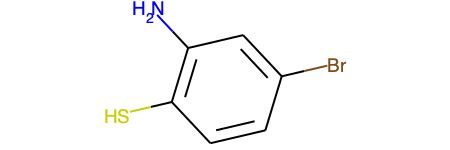

In [471]:
T_ABT[4]

In [488]:
"""run enumeration (consumes lots of RAM)"""

products = EnumerateReaction(rxn_ABT, ([I[0]], [M[0]], T_ABT), uniqueProductsOnly=True)

RDKit WARNING: [17:58:25] product atom-mapping number 2 found multiple times.
RDKit WARNING: [17:58:25] product atom-mapping number 1 found multiple times.
RDKit WARNING: [17:58:25] product atom-mapping number 4 found multiple times.
RDKit WARNING: [17:58:25] product atom-mapping number 5 found multiple times.
RDKit WARNING: [17:58:25] product atom-mapping number 6 found multiple times.
RDKit WARNING: [17:58:25] product atom-mapping number 7 found multiple times.
RDKit WARNING: [17:58:25] product atom-mapping number 1 found multiple times.
RDKit WARNING: [17:58:25] product atom-mapping number 3 found multiple times.
RDKit WARNING: [17:58:25] product atom-mapping number 2 found multiple times.
RDKit WARNING: [17:58:25] product atom-mapping number 7 found multiple times.
RDKit WARNING: [17:58:25] product atom-mapping number 6 found multiple times.
RDKit WARNING: [17:58:25] product atom-mapping number 5 found multiple times.
RDKit WARNING: [17:58:25] product atom-mapping number 4 found mu

In [489]:
prds = list(products)
prds

[(<rdkit.Chem.rdchem.Mol at 0x13d94fc90>,
  <rdkit.Chem.rdchem.Mol at 0x13f2e12d0>),
 (<rdkit.Chem.rdchem.Mol at 0x13f2e0330>,
  <rdkit.Chem.rdchem.Mol at 0x13f2e0570>),
 (<rdkit.Chem.rdchem.Mol at 0x13f2e1330>,
  <rdkit.Chem.rdchem.Mol at 0x13f2e1570>),
 (<rdkit.Chem.rdchem.Mol at 0x13f2e0630>,
  <rdkit.Chem.rdchem.Mol at 0x13f2e0870>),
 (<rdkit.Chem.rdchem.Mol at 0x13f2e1630>,
  <rdkit.Chem.rdchem.Mol at 0x13f2e1870>),
 (<rdkit.Chem.rdchem.Mol at 0x13f2e0ab0>,
  <rdkit.Chem.rdchem.Mol at 0x13f2e0cf0>),
 (<rdkit.Chem.rdchem.Mol at 0x13f2e1930>,
  <rdkit.Chem.rdchem.Mol at 0x13f2e1b70>),
 (<rdkit.Chem.rdchem.Mol at 0x13f2e0db0>,
  <rdkit.Chem.rdchem.Mol at 0x13f2e4030>),
 (<rdkit.Chem.rdchem.Mol at 0x13f2e1c30>,
  <rdkit.Chem.rdchem.Mol at 0x13f2e1e70>),
 (<rdkit.Chem.rdchem.Mol at 0x13f2e40f0>,
  <rdkit.Chem.rdchem.Mol at 0x13f2e4330>),
 (<rdkit.Chem.rdchem.Mol at 0x13f2e1f30>,
  <rdkit.Chem.rdchem.Mol at 0x13f2e31b0>),
 (<rdkit.Chem.rdchem.Mol at 0x13f2e43f0>,
  <rdkit.Chem.rdchem.Mo

In [490]:
"""Add name properties to enumerated molecules. The cartesian enumeration strategy is (0,0,0), (1,0,0),...
WARNING:  This only works for enumeration of the complete library."""
# TODO adapt to flexible use case

names = [f'{i.GetProp("_Name")} + {m.GetProp("_Name")} + {t.GetProp("_Name")}' for t in T_ABT for m in M for i in I]
print(names[:5])
[p.SetProp('_Name', n) for p_list, n in zip(prds, names) for p in p_list]

['2-Pyr002 + Fused002 + TerABT001', '2-Pyr003 + Fused002 + TerABT001', '2-Pyr005 + Fused002 + TerABT001', '2-Pyr006 + Fused002 + TerABT001', '2-Pyr007 + Fused002 + TerABT001']


[None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None]

In [498]:
prds[17][4].GetProp('_Name')

'4-Pyrazole002 + Fused002 + TerABT001'

In [486]:
[Chem.SanitizeMol(p) for p_list in prds for p in p_list]

[rdkit.Chem.rdmolops.SanitizeFlags.SANITIZE_NONE,
 rdkit.Chem.rdmolops.SanitizeFlags.SANITIZE_NONE,
 rdkit.Chem.rdmolops.SanitizeFlags.SANITIZE_NONE,
 rdkit.Chem.rdmolops.SanitizeFlags.SANITIZE_NONE,
 rdkit.Chem.rdmolops.SanitizeFlags.SANITIZE_NONE,
 rdkit.Chem.rdmolops.SanitizeFlags.SANITIZE_NONE,
 rdkit.Chem.rdmolops.SanitizeFlags.SANITIZE_NONE,
 rdkit.Chem.rdmolops.SanitizeFlags.SANITIZE_NONE,
 rdkit.Chem.rdmolops.SanitizeFlags.SANITIZE_NONE,
 rdkit.Chem.rdmolops.SanitizeFlags.SANITIZE_NONE,
 rdkit.Chem.rdmolops.SanitizeFlags.SANITIZE_NONE,
 rdkit.Chem.rdmolops.SanitizeFlags.SANITIZE_NONE,
 rdkit.Chem.rdmolops.SanitizeFlags.SANITIZE_NONE,
 rdkit.Chem.rdmolops.SanitizeFlags.SANITIZE_NONE,
 rdkit.Chem.rdmolops.SanitizeFlags.SANITIZE_NONE,
 rdkit.Chem.rdmolops.SanitizeFlags.SANITIZE_NONE,
 rdkit.Chem.rdmolops.SanitizeFlags.SANITIZE_NONE,
 rdkit.Chem.rdmolops.SanitizeFlags.SANITIZE_NONE,
 rdkit.Chem.rdmolops.SanitizeFlags.SANITIZE_NONE,
 rdkit.Chem.rdmolops.SanitizeFlags.SANITIZE_NONE,


In [476]:
resorted_products = list(map(list, itertools.zip_longest(*prds, fillvalue=None)))  # "transposes" the list of lists
resorted_products

[[<rdkit.Chem.rdchem.Mol at 0x1400b9c90>,

In [477]:
resorted_products[0][0].HasProp('_Name')

0

In [478]:
for p, s in zip(resorted_products, string.ascii_uppercase):
    with open(OUTPUT_DIR / 'sdf' / f'product_{s}.sdf', 'w') as file:
        writer = Chem.SDWriter(file)
        [writer.write(mol) for mol in p]
        writer.close()
    print(f'Products {s} were saved to SDF')

Products A were saved to SDF
Products B were saved to SDF
Products C were saved to SDF
Products D were saved to SDF
Products E were saved to SDF
Products F were saved to SDF
Products G were saved to SDF


TODO find out how to add monomer info to sdf

In [479]:
m = T_ABT[1]
m2 = m
m2.SetProp('_Name', 'TerTH002')
m2.GetProp('_Name')


'TerTH002'

In [480]:
with open(OUTPUT_DIR / 'sdf' / f'test.sdf', 'w') as file:
        writer = Chem.SDWriter(file)
        writer.write(m2)
        writer.close()

In [481]:
"""Save products to SDF"""

'Save products to SDF'